In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.sparse as sp

from tqdm import tqdm

sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
FILE = "out/results/GAT_2024-11-01-16-19-45_results_0.h5ad"

In [3]:
adata = ad.read_h5ad(FILE)

In [4]:
FOLD = 0
N_HEADS_1 = adata.uns["att_1_f0_val"]['10100574'].shape[1]
N_HEADS_2 = adata.uns["att_2_f0_val"]['10100574'].shape[1]
DONORS = sorted(adata.obs['Donor ID'].unique())

In [5]:
att_l1 = np.zeros((len(adata), N_HEADS_1))  # Received attention from layer 1
att_l2 = np.zeros((len(adata), N_HEADS_2))  # Received attention from layer 2
degree = np.zeros(len(adata))
att_l1_cor = np.zeros((len(adata), N_HEADS_1))  # Corrected for degree
att_l2_cor = np.zeros((len(adata), N_HEADS_2))
att_l1_cor_sqrt = np.zeros((len(adata), N_HEADS_1))  # Corrected for degree and square root
att_l2_cor_sqrt = np.zeros((len(adata), N_HEADS_2))

donor_offset = 0
for donor in tqdm(DONORS):
    donor_adata = adata[adata.obs['Donor ID'] == donor]
    donor_idx = donor_adata.obs.index
    
    # Layer 1
    pos = adata.uns["att_1_f0_pos"][str(donor)]
    val = adata.uns["att_1_f0_val"][str(donor)]
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        att_l1[donor_offset + recv] += val[i]
        degree[donor_offset + recv] += 1
    donor_mean_degree = degree[donor_offset:donor_offset + len(donor_adata)].mean()
        
    # Layer 2
    pos = adata.uns["att_2_f0_pos"][str(donor)]
    val = adata.uns["att_2_f0_val"][str(donor)]
    for i in range(pos.shape[1]):
        recv, send = pos[:, i]
        att_l2[donor_offset + recv] += val[recv]
    
    # Correct for degree 
    att_l1_cor[donor_offset:donor_offset + len(donor_adata)] = \
        att_l1[donor_offset:donor_offset + len(donor_adata)] / degree[donor_offset:donor_offset + len(donor_adata)][:, None] * donor_mean_degree
    att_l2_cor[donor_offset:donor_offset + len(donor_adata)] = \
        att_l2[donor_offset:donor_offset + len(donor_adata)] / degree[donor_offset:donor_offset + len(donor_adata)][:, None] * donor_mean_degree
        
    # And using square root to moderate the effect of the correction a bit
    att_l1_cor_sqrt[donor_offset:donor_offset + len(donor_adata)] = \
        att_l1[donor_offset:donor_offset + len(donor_adata)] * np.sqrt(donor_mean_degree / degree[donor_offset:donor_offset + len(donor_adata)][:, None])
    att_l2_cor_sqrt[donor_offset:donor_offset + len(donor_adata)] = \
        att_l2[donor_offset:donor_offset + len(donor_adata)] * np.sqrt(donor_mean_degree / degree[donor_offset:donor_offset + len(donor_adata)][:, None])

    donor_offset += len(donor_adata)

100%|██████████| 339/339 [05:55<00:00,  1.05s/it]


In [6]:
adata.obs["degree"] = degree
adata.obsm["att_l1"] = att_l1
adata.obsm["att_l2"] = att_l2
adata.obsm["att_l1_cor"] = att_l1_cor
adata.obsm["att_l2_cor"] = att_l2_cor
adata.obsm["att_l1_cor_sqrt"] = att_l1_cor_sqrt
adata.obsm["att_l2_cor_sqrt"] = att_l2_cor_sqrt

# Write to file
# adata.write_h5ad(FILE.replace(".h5ad", "_att.h5ad"), compression='gzip')

In [3]:
# Load from checkpoint
adata = ad.read_h5ad(FILE.replace(".h5ad", "_att.h5ad"))

In [7]:
FOLD = 0
N_HEADS_1 = adata.uns["att_1_f0_val"]['10100574'].shape[1]
N_HEADS_2 = adata.uns["att_2_f0_val"]['10100574'].shape[1]
DONORS = sorted(adata.obs['Donor ID'].unique())

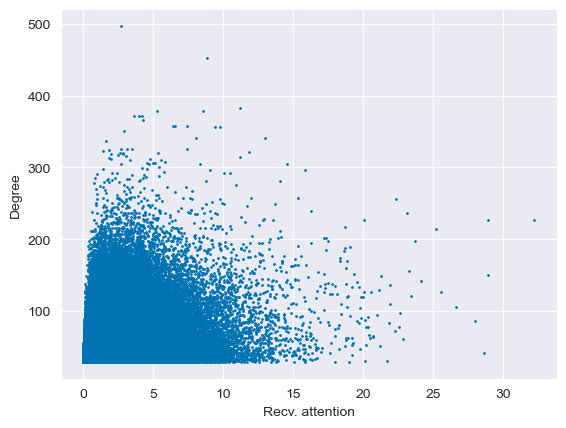

In [8]:
plt.scatter(
    adata.obsm['att_l1'][:, 0],
    adata.obs['degree'],
    s = 1,
)
plt.ylabel("Degree")
plt.xlabel("Recv. attention")
plt.show()

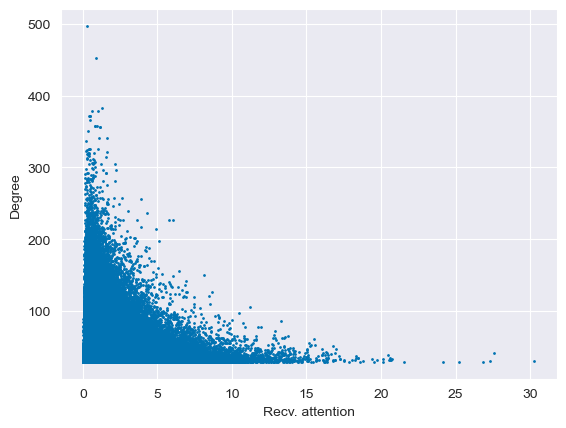

In [9]:
plt.scatter(
    adata.obsm['att_l1_cor'][:, 0],
    adata.obs['degree'],
    s = 1,
)
plt.ylabel("Degree")
plt.xlabel("Recv. attention")
plt.show()

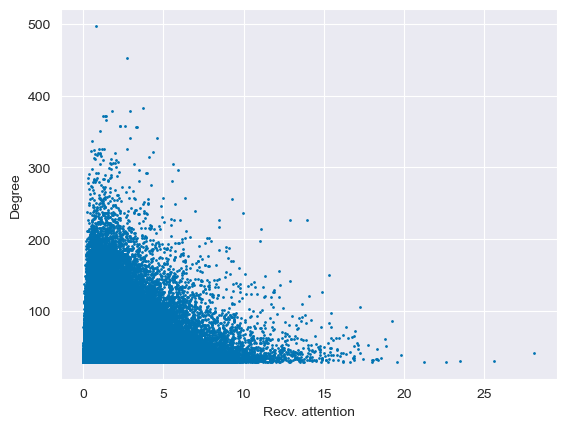

In [10]:
plt.scatter(
    adata.obsm['att_l1_cor_sqrt'][:, 0],
    adata.obs['degree'],
    s = 1,
)
plt.ylabel("Degree")
plt.xlabel("Recv. attention")
plt.show()

In [11]:
# Correlation between attention and degree (to show why we normalize it)

degree = adata.obs["degree"]
# Layer 1
print("Layer 1")
for head in range(N_HEADS_1):
    att_l1_head = adata.obsm["att_l1"][:, head]
    att_l1_cor_head = adata.obsm["att_l1_cor"][:, head]
    att_l1_cor_sqrt_head = adata.obsm["att_l1_cor_sqrt"][:, head]
    corr = np.corrcoef(att_l1_head, degree)[0, 1]
    cor_corr = np.corrcoef(att_l1_cor_head, degree)[0, 1]
    cor_sqrt_corr = np.corrcoef(att_l1_cor_sqrt_head, degree)[0, 1]
    print(f"Head {head}: {corr:.2f} (vs {cor_corr:.2f}, vs {cor_sqrt_corr:.2f})")
    
# Layer 2
print("\nLayer 2")
for head in range(N_HEADS_2):
    att_l2_head = adata.obsm["att_l2"][:, head]
    att_l2_cor_head = adata.obsm["att_l2_cor"][:, head]
    att_l2_cor_sqrt_head = adata.obsm["att_l2_cor_sqrt"][:, head]
    corr = np.corrcoef(att_l2_head, degree)[0, 1]
    cor_corr = np.corrcoef(att_l2_cor_head, degree)[0, 1]
    cor_sqrt_corr = np.corrcoef(att_l2_cor_sqrt_head, degree)[0, 1]
    print(f"Head {head}: {corr:.2f} (vs {cor_corr:.2f}, vs {cor_sqrt_corr:.2f})")

Layer 1
Head 0: 0.35 (vs -0.03, vs 0.15)
Head 1: 0.36 (vs -0.01, vs 0.16)
Head 2: 0.35 (vs -0.02, vs 0.15)
Head 3: 0.35 (vs -0.02, vs 0.15)
Head 4: 0.29 (vs -0.02, vs 0.12)
Head 5: 0.42 (vs -0.02, vs 0.19)
Head 6: 0.30 (vs -0.02, vs 0.12)
Head 7: 0.35 (vs -0.02, vs 0.15)

Layer 2
Head 0: 0.64 (vs 0.00, vs 0.35)
Head 1: 0.67 (vs 0.00, vs 0.37)
Head 2: 0.61 (vs 0.00, vs 0.33)
Head 3: 0.59 (vs 0.00, vs 0.31)


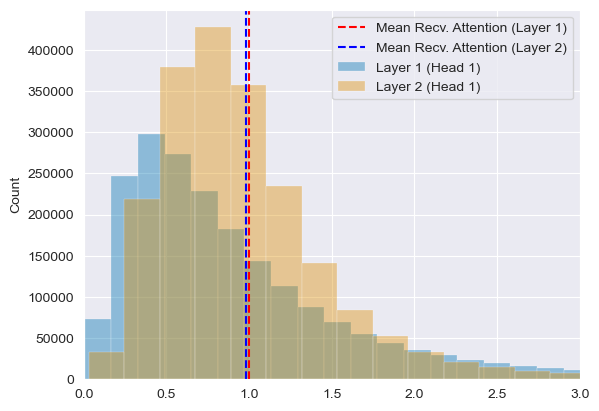

In [12]:
# Plot total attention distribution
sns.histplot(att_l1[:, 0], bins=200, label='Layer 1 (Head 1)', alpha=0.4)
sns.histplot(att_l2[:, 0], bins=200, label='Layer 2 (Head 1)', alpha=0.4)
plt.xlim(0, 3)

# Plot vertical line at mean
plt.axvline(att_l1[:, 0].mean(), color='red', linestyle='--', label='Mean Recv. Attention (Layer 1)')
plt.axvline(att_l2[:, 0].mean(), color='blue', linestyle='--', label='Mean Recv. Attention (Layer 2)')

plt.legend()
plt.show()

In [13]:
adata.obs["Celltype"] = adata.obs["Supertype"].map({
    "Astrocytes": "Astrocytes",
    "Excitatory_neurons_set1": "Excitatory neurons",
    "Excitatory_neurons_set2": "Excitatory neurons",
    "Excitatory_neurons_set3": "Excitatory neurons",
    "Inhibitory_neurons": "Inhibitory neurons",
    "Immune_cells": "Immune cells",
    "Oligodendrocytes": "Oligodendrocytes",
    "OPCs": "OPCs",
    "Vasculature_cells": "Vascular",
})

In [14]:
CELLTYPES_MAJOR = sorted(adata.obs['Celltype'].unique())
CELLTYPES_MINOR = sorted(adata.obs['cell_type_high_resolution'].unique())

celltypes = CELLTYPES_MAJOR
ct_recv_att = np.zeros((len(celltypes), len(DONORS), N_HEADS_1 + N_HEADS_2))

donor_masks = {}
for donor in DONORS:
    donor_masks[donor] = (adata.obs['Donor ID'] == donor)

ct_masks = {}
for ct in celltypes:
    ct_masks[ct] = (adata.obs['Celltype'] == ct)  # ALSO CHANGE COLUMN HERE
    
# 4.1s
    
for j, donor in enumerate(tqdm(DONORS)):
    for i, ct in enumerate(celltypes):
        adata_subs = adata[donor_masks[donor] & ct_masks[ct]]
        if len(adata_subs) == 0:
            continue
        ct_recv_att[i, j, :N_HEADS_1] = adata_subs.obsm["att_l1_cor"].mean(axis=0)
        ct_recv_att[i, j, N_HEADS_1:] = adata_subs.obsm["att_l2_cor"].mean(axis=0)

100%|██████████| 339/339 [00:09<00:00, 37.07it/s]


In [15]:
pd.DataFrame(ct_recv_att[:, :, 0], columns=DONORS, index=celltypes)

,1211411,3713990,3889845,6804844,7253015,7265221,7311370,8109170,9841821,10100574,...,92393245,92629514,93815598,94092977,94144536,94430339,95491648,95919181,96095092,98953007
Astrocytes,1.019864,0.950311,1.157968,1.066158,1.066104,0.928635,0.979495,0.926065,1.144411,1.003613,...,1.129627,0.998142,0.956852,1.111852,1.022533,1.063460,1.161710,1.062598,0.889358,1.042684
Excitatory neurons,1.046717,1.054299,1.004064,0.959247,0.969133,1.005199,1.017907,0.931177,0.988032,1.013640,...,1.039981,1.091952,0.980794,0.998729,1.011191,1.007687,1.010745,1.064033,1.024478,1.003688
Immune cells,1.020830,1.056332,0.988463,1.054851,0.883448,1.024627,1.064845,0.898677,1.120236,0.973824,...,0.931873,0.930191,1.058780,0.986844,0.851760,0.945246,0.941550,0.000000,0.859211,0.987208
Inhibitory neurons,0.945509,0.941693,1.026463,0.943935,1.005336,1.247987,1.057770,0.960189,1.167706,0.987414,...,1.016856,0.973634,1.026458,0.989465,0.972949,0.972276,0.969630,0.973685,1.140356,0.958266
OPCs,0.911945,0.942289,1.161266,0.921343,1.063945,1.038019,1.064216,1.108917,1.059735,0.950046,...,0.989136,1.078004,1.047293,0.988922,0.975572,1.019280,1.105161,0.863233,0.964072,1.049037
Oligodendrocytes,1.003453,1.055531,1.028320,1.069012,1.057153,1.073817,0.967093,1.093404,1.069348,1.052868,...,0.985939,1.010384,0.994241,1.038108,0.993494,1.027409,1.022184,1.003234,0.885073,0.978846
Vascular,1.231372,1.048685,1.095082,1.129590,1.099091,1.141920,0.890132,1.411867,0.919263,0.913146,...,0.917803,0.857354,0.939679,1.199969,1.037802,1.030157,1.131443,0.897156,1.144476,0.977549


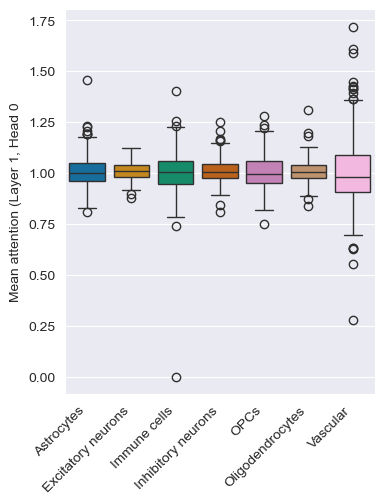

In [17]:
# Violin plot for just the first head,
# group x axis by major cell type, 
# y is mean attention per donor

df = pd.DataFrame(ct_recv_att[:, :, 0], columns=DONORS, index=celltypes)

plt.figure(figsize=(4, 5), dpi=100)
sns.boxplot(data=df.T)
plt.ylabel("Mean attention (Layer 1, Head 0")

# Rotate x labels
plt.xticks(rotation=45, ha='right')
plt.show()

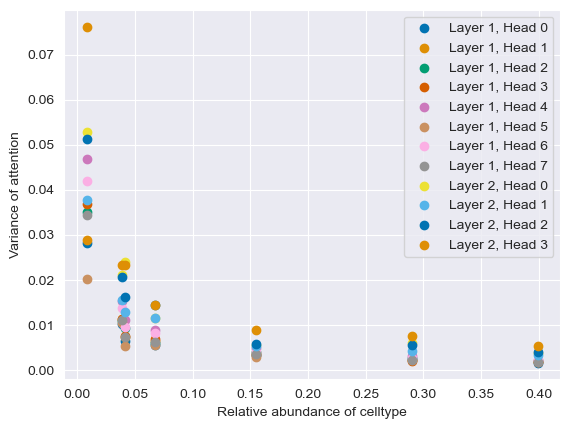

In [ ]:
for head in range(12):

    df = pd.DataFrame(ct_recv_att[:, :, head], columns=DONORS, index=celltypes)
    ct_att_var = df.var(axis=1)

    # Plot variance of attention per celltype compared to relative abundance
    ct_rel_ab = adata.obs["Celltype"].value_counts(normalize=True)
    ct_rel_ab = ct_rel_ab[CELLTYPES_MAJOR]
    
    label = f"Layer 1, Head {head}" if head < N_HEADS_1 else f"Layer 2, Head {head - N_HEADS_1}"
    plt.scatter(ct_rel_ab, ct_att_var, label=label)
plt.xlabel("Relative abundance of celltype")
plt.ylabel("Variance of attention")
plt.legend()
plt.show()


# Correlation between received attention and gene expression

In [18]:
gene_scores = []

celltype = "Astrocytes"
# celltype = "Excitatory neurons"
# celltype = "Inhibitory neurons"
# celltype = "Immune cells"
# celltype = "Oligodendrocytes"
# celltype = "OPCs"
# celltype = "Vascular"

adata_ct = adata[adata.obs['Celltype'] == celltype]

x = adata_ct.X.tocsc()

for j, gene in enumerate(tqdm(adata.var_names)):
    col = adata_ct.obsm["att_l1"][:, 0]
    gene_expr = x[:, j].toarray().flatten()
    gene_scores.append(st.spearmanr(col, gene_expr)[0])
    
    for i in range(N_HEADS_1 + N_HEADS_2):
        if i < N_HEADS_1:
            col = adata_ct.obsm["att_l1"][:, i]
        else:
            col = adata_ct.obsm["att_l2"][:, i - N_HEADS_1]
        s = st.spearmanr(col, gene_expr)[0]
        if abs(s) > abs(gene_scores[j]):  # If it's more extreme
            gene_scores[j] = s

 73%|███████▎  | 728/1000 [05:06<01:53,  2.39it/s]C:\Users\timo\AppData\Local\Temp\ipykernel_509488\1231780237.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  gene_scores.append(st.spearmanr(col, gene_expr)[0])
C:\Users\timo\AppData\Local\Temp\ipykernel_509488\1231780237.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s = st.spearmanr(col, gene_expr)[0]
100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


<Axes: ylabel='Count'>

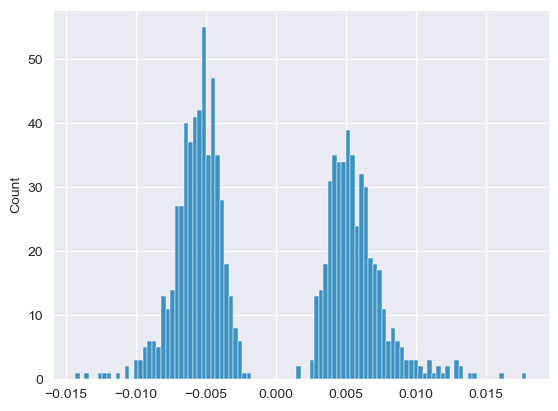

In [19]:
sns.histplot(gene_scores, bins=100)

In [ ]:
df = pd.DataFrame({
    "Gene": adata.var_names,
    "Score": gene_scores
})

# Sort by absolute value
df["score_abs"] = df["Score"].abs()
df = df.sort_values("score_abs", ascending=False)
df = df.drop("score_abs", axis=1)

df.head(20)

,Gene,Score
252,ANTXR2,-0.033140
634,NEAT1,0.025581
279,TTC29,0.022748
753,CUX2,-0.022665
803,FOS,0.022175
82,AC068599.1,-0.021518
368,HTR4,0.021110
854,RPL3L,-0.020576
362,EGR1,0.020509
656,CLMP,-0.020305


In [ ]:
# GSEA
import gseapy as gp

In [ ]:
raw_response = gp.prerank(
    rnk=df, 
    gene_sets=[
        # Disease phenotype related:
        # "DisGeNET",
        # "OMIM_Disease",
        # "OMIM_Expanded",
        # "UK_Biobank_GWAS_v1",
        # "Jensen_DISEASES"
        # "GWAS_Catalog_2023",
        # "Human_Phenotype_Ontology",

        # Brain-specific:
        # "PanglaoDB_Augmented_2021",
        # "Aging_Perturbations_from_GEO_down",
        # "Aging_Perturbations_from_GEO_up",
        # "Allen_Brain_Atlas_10x_scRNA_2021",
        # "Allen_Brain_Atlas_down",
        # "Allen_Brain_Atlas_up",
        
        "GO_Biological_Process_2023",
        # "GO_Cellular_Component_2023",
        # "GO_Molecular_Function_2023"
        # "GTEx_Aging_Signatures_2021",
        # "HDSigDB_Human_2021",
        "KEGG_2021_Human",


        # "Azimuth_Cell_Types_2021",
        # "WikiPathways_2024_Human",

        # "Chromosome_Location",
    ],
    # outdir="out/results/gsea/Ast_GO-2023", 
    min_size=1,  # (default = 15)
    max_size=10000,  # (default = 500)
    # permutation_num=1000,
    verbose=True,
)

2024-11-22 16:39:37,929 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-11-22 16:39:37,932 [INFO] Parsing data files for GSEA.............................
2024-11-22 16:39:37,932 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-22 16:39:37,971 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-22 16:39:38,041 [INFO] 2728 gene_sets have been filtered out when max_size=10000 and min_size=1
2024-11-22 16:39:38,042 [INFO] 2999 gene_sets used for further statistical testing.....
2024-11-22 16:39:38,042 [INFO] Start to run GSEA...Might take a while..................
2024-11-22 16:39:41,895 [INFO] Congratulations. GSEApy runs successfully................



In [ ]:
res = raw_response.res2d.copy()
alz_terms = res[res["Term"].str.contains("Alz")]
alz_terms.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2004,prerank,KEGG_2021_Human__Alzheimer disease,0.298269,0.882937,0.643243,0.944491,1.0,4/15,10.35%,CHRM5;GAPDH;TUBB2A;BACE2


In [ ]:
# Show only significant results, sorted by absolute NES
res_sig = res[res["FDR q-val"] < 0.05].copy()
res_sig.insert(0, "abs_NES", res_sig["NES"].abs())
res_sig.sort_values("NES", ascending=False, inplace=True)
n_sig = res_sig.shape[0]
print(f"Found {n_sig} significant terms")
res_sig.head(20).drop(columns=["abs_NES", "Name"])

Found 0 significant terms


,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


In [ ]:
if n_sig > 0:
    top_terms = min(50, n_sig)

    gp.plot.dotplot(
        df = res,
        # column = "NOM p-val",
        column = "FDR q-val",  # Should use this one (corrected p-value)
        # column = "NES",
        top_term=top_terms,
        figsize=(8, top_terms),
        size=7,
        cutoff=0.05,
    )